In [124]:
import numpy as np
from tqdm import tqdm
import random
from itertools import product

In [28]:
# Make a wrapper class for episode frames

class Frame:
    '''
    Wrapper for frames of each episode
    '''
    state = None         # current state
    action = None        # action
    reward = 0           # reward
    next_state = None    # next state
    terminated = False   # termination flag
    
    def __init__(self, state, action, next_state, reward, terminated):
        '''
        Constructs this frame object
        INPUT
            state; current state
            action; taken action
            reward; received reward
            next_state; next state
            termination; boolean termination flag
        '''
        self.state = state
        self.action = action
        self.next_state = next_state
        self.reward = reward
        self.terminated = terminated
                        
            
# Define capacitated queue for replay memory.            
            
class CapacitatedQueue:
    '''
    A queue with maximum capacity. If any items are added when at capacity, then oldest items are pushed out.
    '''
    collection = []  # items in this collection
    capacity = 128   # max capacity
    next_ind = 0     # index of the next item to be added
    
    def __init__(self, capacity=128):
        '''
        Intializes this model
        INPUT
            capacity; the maximum capacity of this colleciotn
        '''
        self.capacity = capacity
        self.next_ind = 0
        self.collection = []
        
    def __len__():
        '''
        RETURNS length of the collection
        '''
        return len(self.collection)
        
    def add(self, item):
        '''
        Adds the given item into the collection.
        If the collection is at capacity, push out oldest item
        '''
        # If not at capacity, add in item
        if len(self.collection) < self.capacity:
            self.collection.append(item)
            
        # If at capacity, replace oldest item
        else:
            self.collection[self.next_ind] = item
            
        # Track the index of the next/oldest item
        self.next_ind = (self.next_ind + 1) % self.capacity

    def sample(self, size=1):
        '''
        RETURNS a (with-replacement) sample of the given size from the collection
        '''
        return np.random.choice(self.collection, size, replace=True).tolist()
    
    def get_next(self):
        '''
        RETURNS the next item in the collection
        '''
        return self.collection[(next_ind - 1) % self.capacity]

In [272]:
from copy import deepcopy

class VersusLearner:
    '''
    Class for approximating V function for a two player, zero-sum, symetrical game
    '''
    env = None              # associated envionment
    estimator = None        # the fitted function to estimate V, like a neural network
    replay_memory = None    # replay memory
        
    def __init__(self, env, estimator, replay_capacity=10**4):
        '''
        Intializes this object
        INPUT
            env; environment
            estimator; trainable function to estimate V
            replay_capacity; size of replay memory
        '''
        self.env = env
        self.estimator = estimator
        self.replay_memory = CapacitatedQueue(replay_capacity)
        
    def get_action(self, state, epsilon=0., discount_factor=0.99):
        '''
        Gets the action to take
        INPUT
            state; the current state, as would be input to the Q approximator
            epsilon; the epsilon-greedy parameter
                if 0; plays full greedy
            discount_factor; amount to discount the value of next state when computing greedy action selection
        RETURNS
            action to take
        '''
        # Explore
        if (epsilon > 0) and (np.random.uniform() < epsilon):
            return random.choice(self.env.get_legal_actions())
                
        # Greedy
        next_states = []
        rewards = []
        terminateds = []
        
        # Lookahead for each action's outcome
        legal_actions = self.env.get_legal_actions()
        for act in legal_actions:
            lookahead_env = deepcopy(self.env)
            next_state, reward, terminated = lookahead_env.step(act)
            next_state = self.env.parse_board(next_state)
            next_states.append(next_state)
            rewards.append(reward)
            terminateds.append(terminated)
        nonterminateds = (1 - np.array(terminateds)).astype(bool)      
        next_states = [ns for ind, ns in enumerate(next_states) if nonterminateds[ind]]
        next_states = np.array(next_states).reshape([len(next_states)] + list(self.env.get_observation_space_shape()) + [1])
        
        # Bootstrap the value of the next states
        action_values = np.array(rewards, dtype=float)
        if np.sum(nonterminateds):
            action_values[nonterminateds] += -discount_factor * self.estimator.predict(next_states, verbose=0)[:, 0]
        
        return legal_actions[np.argmax(action_values)]
            
    def train(self, n_steps=10**3, epsilon=0.2, training_delay=32, batch_size=32, discount_factor=0.99):
        '''
        Trains this model
        INPUT
            n_steps; number of steps to train
            epsilon; epsilon-greedy threshold
            training_delay; number of steps to train before fitting approximator
            batch_size; number of frames to train approximator with
            discount_factor; discount factor in bellman
        RETURNS
            list of episode rewards
        '''
        # Initialize
        episode_counter = 0
        delay_counter = 0
        reward_history = [0]
        
        # First state
        state = self.env.parse_board(self.env.reset())
        
        # Train for each step
        pbar = tqdm(range(n_steps))
        for _ in pbar:
            
            # Get action
            action = self.get_action(state, epsilon)
            
            # Make step
            next_state, reward, terminated = self.env.step(action)
            next_state = self.env.parse_board(next_state)
            
            # Save frame
            self.replay_memory.add(Frame(state, action, next_state, reward, terminated))
            reward_history[-1] += -self.env.player * reward
            
            # If terminated, record reward and reset
            if terminated:
                state = self.env.parse_board(self.env.reset())
                pbar.set_description(f"Last episode reward: {reward_history[-1]}")
                pbar.update()
                reward_history.append(0)
            else:
                state = next_state
                
            # If training_delay steps have occurred, then train
            delay_counter += 1
            if delay_counter >= training_delay:
                delay_counter = 0
                
                # Get minibatch params
                frame_batch = self.replay_memory.sample(batch_size)
                states = np.array([frame.state for frame in frame_batch])
                rewards = np.array([frame.reward for frame in frame_batch], dtype=float)
                next_states = np.array([frame.next_state for frame in frame_batch]).reshape(batch_size, -1)
                nonterminateds = (1 - np.array([frame.terminated for frame in frame_batch])).astype(bool)
                next_states = [frame.next_state for ind, frame in enumerate(frame_batch) if nonterminateds[ind]]
                next_states = np.array(next_states).reshape([len(next_states)] + list(self.env.get_observation_space_shape()) + [1])
                
                # Get training targets
                targets = rewards
                if np.sum(nonterminateds):
                    targets[nonterminateds] += -discount_factor * self.estimator.predict(next_states, verbose=0)[:, 0]
                
                # Train
                self.estimator.fit(states, targets, epochs=1, verbose=0)
        
        return reward_history

In [37]:
from abc import ABC, abstractmethod

class VersusEnv(ABC):
    
    @abstractmethod
    def __init__(self, **kwargs):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    
    @abstractmethod
    def step(self, action):
        pass
    
    @abstractmethod
    def get_observation_space_shape(self):
        pass

    @abstractmethod
    def get_legal_actions(self):
        pass
    
    @abstractmethod
    def parse_board(self, board):
        pass

In [287]:
# from gym_connect4_master.connect4_env import Connect4Env as C4Env
from gym_tictactoe_master.tictactoe_env import TicTacToeEnv as TTTEnv

class VersusTicTacToe(VersusEnv):
    
    env = None
    player = 1
    
    def __init__(self, **kwargs):
        self.env = TTTEnv(kwargs)
        self.env.small = 0.
        self.env.large = 1.
        self.player = 1
        
    def reset(self):
        state, _ = self.env.reset()
        self.player = 1
        return state
    
    def step(self, action):
        flat_action = np.arange(0, 9, 1).reshape(3, 3)[action]
        state, reward, terminated, _ = self.env.step((flat_action, (self.player + 1) / 2 + 1))
        if np.sum(state == 0) == 0:
            terminated = True
        self.player = -self.player
        return state, reward, terminated
    
    def get_observation_space_shape(self):
        return (3, 3, 2)
    
    def get_legal_actions(self):
        legal_actions = [(row, col) for row, col in product(range(3), range(3))
               if self.env.state[row, col] == 0]
        return legal_actions
    
    def parse_board(self, board, perspective=None):
        if perspective is None:
            perspective = self.player
        reshaped = board.reshape(3, 3)
        parsed = np.zeros((3, 3, 2))
        parsed[reshaped == (perspective + 1) / 2 + 1, 0] = 1
        parsed[reshaped == (-perspective + 1) / 2 + 1, 1] = 1
        return parsed

In [298]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

ttt_env = VersusTicTacToe()

# Build the model
model = Sequential([
    Input(shape=(3, 3, 2)),
    Conv2D(16, kernel_size=(2, 2), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, kernel_size=(2, 2), activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(loss='mse',
              optimizer='adam')

# Model summary
model.summary()

# print(ttt_env.step((1, 0)))

ttt_learner = VersusLearner(ttt_env, model)
reward_history = []

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 2, 2, 16)          144       
                                                                 
 conv2d_131 (Conv2D)         (None, 1, 1, 8)           520       
                                                                 
 flatten_113 (Flatten)       (None, 8)                 0         
                                                                 
 dense_318 (Dense)           (None, 32)                288       
                                                                 
 dense_319 (Dense)           (None, 16)                528       
                                                                 
 dense_320 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,497
Trainable params: 1,497
Non-trai

In [299]:
reward_history += ttt_learner.train(n_steps=10**3, epsilon=0.5)
reward_history += ttt_learner.train(n_steps=10**3, epsilon=0.3)
reward_history += ttt_learner.train(n_steps=10**3, epsilon=0.1)
reward_history += ttt_learner.train(n_steps=10**4, epsilon=0.01)

Last episode reward: 0.0: 100%|██████████| 10000/10000 [07:30<00:00, 22.18it/s]


In [305]:
reward_history += ttt_learner.train(n_steps=10**4, epsilon=0.01)

Last episode reward: 0.0:  27%|██▋       | 2655/10000 [01:50<05:04, 24.11it/s] 


KeyboardInterrupt: 

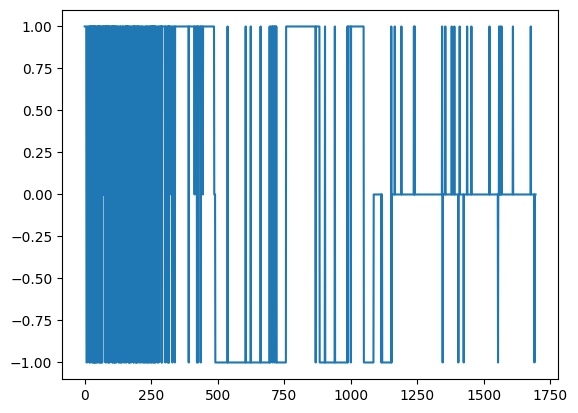

In [300]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.show()

In [304]:
raw_state = ttt_env.reset()
state = ttt_env.parse_board(raw_state, 1)
print(raw_state)
print(ttt_learner.estimator.predict(state.reshape(1, 3, 3, 2), verbose=0))
print()
while True:
    raw_state, _, terminated = ttt_env.step(ttt_learner.get_action(state, epsilon=0.3))
    print(raw_state)
    print(ttt_learner.estimator.predict(state.reshape(1, 3, 3, 2), verbose=0))
    print(ttt_env.player)
    print()
    state = ttt_env.parse_board(raw_state, 1)
    if terminated:
        break    

[0 0 0 0 0 0 0 0 0]
[[-0.1599882]]

[[0 0 0]
 [2 0 0]
 [0 0 0]]
[[-0.1599882]]
-1

[[0 0 0]
 [2 0 1]
 [0 0 0]]
[[0.04686306]]
1

[[0 0 0]
 [2 0 1]
 [0 2 0]]
[[0.45502955]]
-1

[[0 1 0]
 [2 0 1]
 [0 2 0]]
[[0.26039138]]
1

[[0 1 2]
 [2 0 1]
 [0 2 0]]
[[-0.03911069]]
-1

[[0 1 2]
 [2 0 1]
 [1 2 0]]
[[0.07146575]]
1

[[2 1 2]
 [2 0 1]
 [1 2 0]]
[[-0.09190324]]
-1

[[2 1 2]
 [2 0 1]
 [1 2 1]]
[[-0.0019554]]
1

[[2 1 2]
 [2 2 1]
 [1 2 1]]
[[-0.25204274]]
-1

